In [1]:
import pickle
import random

import joblib
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

from utils import extract_sequences_new_idea, train_test_split

In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed()

In [3]:
scaler_target = joblib.load("scaler_prod.save")
scaler_water = joblib.load("scaler_inj.save")

In [4]:
with open('dataset.pkl', 'rb') as file:
    dataset = pickle.load(file)

In [5]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Вычисляет MAPE с защитой от деления на ноль.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Защита от деления на ноль
    epsilon = 1e-8
    y_true = np.where(y_true == 0, epsilon, y_true)

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [6]:
def create_datasets(sequences, targets, node_type='prod'):
    """
    Преобразует последовательности в табличный формат для полносвязных моделей и деревьев.
    X: [N_samples, history_length * F]
    y: [N_samples, prediction_length]
    """
    X = []
    y = []
    for i in range(len(sequences)):
        # Исторические данные (30 дней)
        historical_data = sequences[i]
        # Целевые значения (30 дней в будущем)
        target = targets[i].numpy()  # [N, 30]
        
        # Собираем признаки по времени
        features = []
        for snapshot in historical_data:
            # Извлекаем признаки для заданного типа узла
            feat = snapshot.x_dict[node_type]  # [N, F]
            features.append(feat)
        
        # Конкатенируем признаки по времени: [N, history_length*F]
        combined_features = np.concatenate(features, axis=1)
        
        # Добавляем в общий набор
        X.append(combined_features)
        y.append(target)
    
    # Объединяем все последовательности
    X = np.vstack(X)  # [N_samples, 30*F]
    y = np.vstack(y)  # [N_samples, 30]
    return X, y

def create_lstm_datasets(sequences, targets, node_type='prod'):
    """
    Преобразует данные для LSTM: [N_samples, timesteps, features]
    """
    X = []
    y = []
    for i in range(len(sequences)):
        historical_data = sequences[i]
        target = targets[i].numpy()  # [N, 30]
        
        # Собираем признаки по времени: [timesteps, N, F]
        features = [snapshot.x_dict[node_type] for snapshot in historical_data]
        features = np.stack(features, axis=0)  # [timesteps, N, F]
        
        # Транспонируем для batch-first: [N, timesteps, F]
        features = np.transpose(features, (1, 0, 2))
        
        X.append(features)
        y.append(target)
    
    X = np.vstack(X)  # [N_samples, 30, F]
    y = np.vstack(y)  # [N_samples, 30]
    return X, y

In [7]:
# Извлекаем последовательности
sequences, target_sequences, targets = extract_sequences_new_idea(dataset, 30, 30)

train_sequences, test_sequences, train_targets, test_targets, train_target_sequences, test_target_sequences = train_test_split(sequences, targets, target_sequences, train_ratio=0.8)

# Для полносвязных моделей и деревьев
X_flat_train, y_flat_train = create_datasets(train_sequences, train_targets)
X_flat_test, y_flat_test = create_datasets(test_sequences, test_targets)

# Для LSTM
X_lstm_train, y_lstm_train = create_lstm_datasets(train_sequences, train_targets)
X_lstm_test, y_lstm_test = create_lstm_datasets(test_sequences, test_targets)

# Модели для сравнения

In [16]:
# model_lr = LinearRegression()
# model_lr.fit(X_flat_train, y_flat_train)

LinearRegression()

In [25]:
# joblib.dump(model_lr, "fitted_models/linear_model.pkl")

['linear_model.pkl']

In [8]:
model_lr = joblib.load("fitted_models/linear_model.pkl")

In [91]:
scaler_target.inverse_transform(model_lr.predict(X_flat_test[0].reshape(1, -1)))

array([[789.8664 , 789.86224, 789.5469 , 789.07513, 789.0536 , 789.0821 ,
        788.61127, 788.6393 , 788.6734 , 788.3489 , 787.85126, 787.46545,
        787.62714, 787.4289 , 787.603  , 787.70105, 787.7309 , 787.29517,
        786.8941 , 787.0011 , 786.6447 , 786.354  , 785.86664, 785.8089 ,
        785.61554, 785.29047, 785.2617 , 785.40674, 785.20166, 785.1652 ]],
      dtype=float32)

In [9]:
# Предсказание
y_pred_lr = model_lr.predict(X_flat_test)
y_pred_lr_inv = scaler_target.inverse_transform(y_pred_lr)
y_flat_test_inv = scaler_target.inverse_transform(y_flat_test)

# Метрики
# mae_lr = mean_absolute_error(y_flat_test, y_pred_lr)
# mape_lr = mean_absolute_percentage_error(y_flat_test, y_pred_lr)
mae_lr = mean_absolute_error(y_flat_test_inv, y_pred_lr_inv)
mape_lr = mean_absolute_percentage_error(y_flat_test_inv, y_pred_lr_inv)

print(f"[Linear Regression] MAE: {mae_lr:.4f}, MAPE: {mape_lr:.2f}%")

[Linear Regression] MAE: 11.8847, MAPE: 7.57%


In [18]:
# model_rf = RandomForestRegressor()
# model_rf.fit(X_flat_train, y_flat_train)

RandomForestRegressor()

In [26]:
# joblib.dump(model_rf, "fitted_models/rf_model.pkl")

['rf_model.pkl']

In [9]:
model_rf = joblib.load("fitted_models/rf_model.pkl")

In [65]:
scaler_target.inverse_transform(model_rf.predict(X_flat_test[0].reshape(1, -1)))

array([[795.10124733, 800.87418157, 801.0971123 , 805.01004504,
        807.66297279, 808.95590307, 810.67883151, 812.48176218,
        813.80469235, 815.04762816, 814.26055698, 813.41348564,
        813.67641586, 814.57934712, 814.82227884, 814.35521193,
        812.49813653, 812.47107241, 813.63399955, 813.92985577,
        816.89571931, 818.62158281, 823.35744171, 827.40330584,
        826.78916411, 827.74502308, 827.24088599, 826.21674496,
        826.80260628, 827.3684648 ]])

In [12]:
# Предсказание
y_pred_rf = model_rf.predict(X_flat_test)
y_pred_rf_inv = scaler_target.inverse_transform(y_pred_rf)
y_flat_test_inv = scaler_target.inverse_transform(y_flat_test)

# Метрики
# mae_rf = mean_absolute_error(y_flat_test, y_pred_rf)
# mape_rf = mean_absolute_percentage_error(y_flat_test, y_pred_rf)
mae_rf = mean_absolute_error(y_flat_test_inv, y_pred_rf_inv)
mape_rf = mean_absolute_percentage_error(y_flat_test_inv, y_pred_rf_inv)

print(f"[Random Forest] MAE: {mae_rf:.4f}, MAPE: {mape_rf:.2f}%")

[Random Forest] MAE: 15.6103, MAPE: 14.11%


In [10]:
class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

In [11]:
# Подготовка данных
X_train_tensor = torch.FloatTensor(X_flat_train)
y_train_tensor = torch.FloatTensor(y_flat_train)
X_test_tensor = torch.FloatTensor(X_flat_test)
y_test_tensor = torch.FloatTensor(y_flat_test)

In [21]:
# Модель
model_mlp = SimpleNet(input_dim=X_train_tensor.shape[1], hidden_dim=64, output_dim=30)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)

# Обучение
model_mlp.train()
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model_mlp(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Тестирование
model_mlp.eval()
with torch.no_grad():
    y_pred_mlp = model_mlp(X_test_tensor).numpy()

# Метрики
mae_mlp = mean_absolute_error(y_flat_test, y_pred_mlp)
mape_mlp = mean_absolute_percentage_error(y_flat_test, y_pred_mlp)

print(f"[MLP] MAE: {mae_mlp:.4f}, MAPE: {mape_mlp:.2f}%")

[MLP] MAE: 0.0622, MAPE: 91178956.25%


In [27]:
# torch.save(model_mlp.state_dict(), 'fitted_models/mlp_model.pth')

In [12]:
model_loaded_mlp = SimpleNet(input_dim=X_train_tensor.shape[1], hidden_dim=64, output_dim=30)
model_loaded_mlp.load_state_dict(torch.load('fitted_models/mlp_model.pth'))

<All keys matched successfully>

In [73]:
with torch.no_grad():
    model_loaded_mlp.eval()
    print(scaler_target.inverse_transform(model_loaded_mlp(X_test_tensor[0].reshape(1, -1))))

[[792.55253683 789.34496215 795.57193839 797.60516804 792.3163355
  793.75112876 798.80583725 786.97059259 792.01820967 784.99344956
  794.99037095 784.83152898 791.68007824 793.45278803 793.86856685
  787.02660758 793.77673664 792.54881205 789.30427607 788.79663124
  792.7426798  789.76367781 786.17023002 787.61157746 794.82067847
  786.20088784 790.86485236 795.59647181 787.95855525 798.97556555]]


In [20]:
model_loaded.eval()
with torch.no_grad():
    y_pred_mlp = model_loaded(X_test_tensor).numpy()

y_pred_mlp_inv = scaler_target.inverse_transform(y_pred_mlp)
y_flat_test_inv = scaler_target.inverse_transform(y_flat_test)

mae_mlp = mean_absolute_error(y_flat_test_inv, y_pred_mlp_inv)
mape_mlp = mean_absolute_percentage_error(y_flat_test_inv, y_pred_mlp_inv)

print(f"[MLP] MAE: {mae_mlp:.4f}, MAPE: {mape_mlp:.2f}%")

[MLP] MAE: 18.6876, MAPE: 12.06%


In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Используем последний выход
        return out.unsqueeze(1).repeat(1, 30, 1)  # Дублируем для 30 дней

In [14]:
# Подготовка данных
X_train_lstm_tensor = torch.FloatTensor(X_lstm_train)
y_train_lstm_tensor = torch.FloatTensor(y_lstm_train)
X_test_lstm_tensor = torch.FloatTensor(X_lstm_test)
y_test_lstm_tensor = torch.FloatTensor(y_lstm_test)

# Создаём Dataset и DataLoader
batch_size = 64  # Установите размер батча, подходящий под вашу память
train_dataset = TensorDataset(X_train_lstm_tensor, y_train_lstm_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_lstm_tensor, y_test_lstm_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [37]:
# Модель
model_lstm = LSTMModel(input_dim=X_train_lstm_tensor.shape[2], hidden_dim=64, output_dim=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.0001)

# Обучение
for epoch in range(50):
    model_lstm.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        # Перенос на устройство
        batch_X, batch_y = batch_X, batch_y

        # Forward pass
        outputs = model_lstm(batch_X)
        loss = criterion(outputs.squeeze(-1), batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Валидация
    model_lstm.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X, batch_y
            outputs = model_lstm(batch_X)
            val_loss += criterion(outputs.squeeze(-1), batch_y).item()

    print(f"Epoch {epoch+1}/{50}, "
          f"Train Loss: {total_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(test_loader):.4f}")

# Тестирование
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X, batch_y
            outputs = model(batch_X)
            y_true.append(batch_y.numpy())
            y_pred.append(outputs.squeeze(-1).numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Защита от деления на 0

    return mae, mape

# Метрики
mae_lstm, mape_lstm = evaluate_model(model_lstm, test_loader)

print(f"[LSTM] MAE: {mae_lstm:.4f}, MAPE: {mape_lstm:.2f}%")

Epoch 1/50, Train Loss: 0.0147, Val Loss: 0.0203
Epoch 2/50, Train Loss: 0.0098, Val Loss: 0.0195
Epoch 3/50, Train Loss: 0.0096, Val Loss: 0.0192
Epoch 4/50, Train Loss: 0.0095, Val Loss: 0.0190
Epoch 5/50, Train Loss: 0.0095, Val Loss: 0.0189
Epoch 6/50, Train Loss: 0.0094, Val Loss: 0.0188
Epoch 7/50, Train Loss: 0.0094, Val Loss: 0.0187
Epoch 8/50, Train Loss: 0.0094, Val Loss: 0.0187
Epoch 9/50, Train Loss: 0.0094, Val Loss: 0.0187
Epoch 10/50, Train Loss: 0.0094, Val Loss: 0.0187
Epoch 11/50, Train Loss: 0.0094, Val Loss: 0.0187
Epoch 12/50, Train Loss: 0.0093, Val Loss: 0.0187
Epoch 13/50, Train Loss: 0.0093, Val Loss: 0.0187
Epoch 14/50, Train Loss: 0.0093, Val Loss: 0.0187
Epoch 15/50, Train Loss: 0.0093, Val Loss: 0.0187
Epoch 16/50, Train Loss: 0.0093, Val Loss: 0.0187
Epoch 17/50, Train Loss: 0.0093, Val Loss: 0.0187
Epoch 18/50, Train Loss: 0.0093, Val Loss: 0.0187
Epoch 19/50, Train Loss: 0.0092, Val Loss: 0.0187
Epoch 20/50, Train Loss: 0.0093, Val Loss: 0.0188
Epoch 21/

In [38]:
# torch.save(model_lstm.state_dict(), 'fitted_models/lstm_model.pth')

In [15]:
model_loaded_lstm = LSTMModel(input_dim=X_train_lstm_tensor.shape[2], hidden_dim=64, output_dim=1)
model_loaded_lstm.load_state_dict(torch.load('fitted_models/lstm_model.pth'))

<All keys matched successfully>

In [26]:
def evaluate_model_inv(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X, batch_y
            outputs = model(batch_X)
            y_true.append(batch_y.numpy())
            y_pred.append(outputs.squeeze(-1).numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    y_true_inv = scaler_target.inverse_transform(y_true)
    y_pred_inv = scaler_target.inverse_transform(y_pred)

    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    mape = np.mean(np.abs((y_true_inv - y_pred_inv) / (y_true_inv + 1e-8))) * 100  # Защита от деления на 0

    return mae, mape

mae_lstm, mape_lstm = evaluate_model_inv(model_loaded, test_loader)

print(f"[LSTM] MAE: {mae_lstm:.4f}, MAPE: {mape_lstm:.2f}%")

[LSTM] MAE: 12.3580, MAPE: 9.97%


# Визуализация

In [59]:
idx = 0

y_t = y_lstm_test[idx]
print(scaler_target.inverse_transform(y_t.reshape(1, -1)))
with torch.no_grad():
    model_loaded.eval()
    y_m = model_loaded(X_test_lstm_tensor[idx].unsqueeze(dim=0))
    print(scaler_target.inverse_transform(y_m.squeeze().reshape(1, -1)))

[[789. 791. 797. 812. 821. 822. 830. 833. 836. 839. 839. 840. 848. 847.
  848. 843. 845. 849. 850. 857. 854. 860. 867. 860. 864. 861. 862. 867.
  868. 870.]]
[[792.25133089 792.25133089 792.25133089 792.25133089 792.25133089
  792.25133089 792.25133089 792.25133089 792.25133089 792.25133089
  792.25133089 792.25133089 792.25133089 792.25133089 792.25133089
  792.25133089 792.25133089 792.25133089 792.25133089 792.25133089
  792.25133089 792.25133089 792.25133089 792.25133089 792.25133089
  792.25133089 792.25133089 792.25133089 792.25133089 792.25133089]]


In [30]:
idx = 100

g_true = scaler_target.inverse_transform(y_lstm_test[idx].reshape(1, -1))[0]

gnn_lstm = [64.99636762, 64.44554754, 63.99694409, 63.66402378, 63.40423813,
       63.20338641, 63.04732162, 62.91242362, 62.76964627, 62.63148909,
       62.4959285 , 62.36056491, 62.22457454, 62.08806486, 61.95053444,
       61.80999554, 61.6648902 , 61.51423351, 61.36305749, 61.21965338,
       61.07959799, 60.93540594, 60.78575207, 60.63160339, 60.47663097,
       60.30960672, 60.14118568, 59.97328396, 59.80758488, 59.64611199]

gnn_gru = [ 74.07951757,  80.17913491,  84.62530711,  88.01994465,
        90.65168233,  92.71163014,  94.34322799,  95.65162936,
        96.71441   ,  97.59764898,  98.3345828 ,  98.9753886 ,
        99.54889761, 100.07985814, 100.58671504, 101.08178874,
       101.57220645, 102.0655252 , 102.57471008, 103.10072812,
       103.64110806, 104.2043381 , 104.78766048, 105.39236454,
       106.01089327, 106.65205722, 107.31256138, 107.99229831,
       108.69065916, 109.40757228]

gnn_lstm_no_water = [59.97188717, 59.76695252, 59.64883394, 59.57752585, 59.56294906,
       59.60689433, 59.71408926, 59.88793631, 60.1209859 , 60.31696675,
       60.53988063, 60.79112435, 61.08154992, 61.41201689, 61.78528304,
       62.20038136, 62.65673881, 63.15593125, 63.69734983, 64.28085129,
       64.90650725, 65.57367304, 66.27994904, 67.02279238, 67.7997318 ,
       68.61363252, 69.45926552, 70.33412374, 71.23609407, 72.16227548]

gnn_gru_no_water = [105.50708067, 111.79823777, 115.14269819, 117.61820992,
       119.29052967, 120.57403947, 121.65297276, 122.62732564,
       123.53484733, 124.37227865, 125.12780057, 125.7865856 ,
       126.3419363 , 126.79256331, 127.14487756, 127.40872824,
       127.59597017, 127.71924614, 127.79087656, 127.82199998,
       127.82214325, 127.79979455, 127.7617588 , 127.71258451,
       127.65664115, 127.59822653, 127.53852257, 127.47921258,
       127.4211203 , 127.36438901]

# linear = scaler_target.inverse_transform(model_lr.predict(X_flat_test[idx].reshape(1, -1)))[0]

# rf = scaler_target.inverse_transform(model_rf.predict(X_flat_test[idx].reshape(1, -1)))[0]

# with torch.no_grad():
#     model_loaded_mlp.eval()
#     mlp = scaler_target.inverse_transform(model_loaded_mlp(X_test_tensor[idx].reshape(1, -1)))[0]

# with torch.no_grad():
#     model_loaded_lstm.eval()
#     y_m = model_loaded_lstm(X_test_lstm_tensor[idx].unsqueeze(dim=0))
#     lstm = scaler_target.inverse_transform(y_m.squeeze().reshape(1, -1))[0]

In [31]:
# for res in [linear, gnn_lstm, gnn_gru, rf, mlp, lstm]:
for res in [gnn_lstm, gnn_gru, gnn_lstm_no_water, gnn_gru_no_water]:
    print(mean_absolute_percentage_error(g_true, res))

36.53187757429535
114.16417257435462
38.167432080717276
171.1100920538681


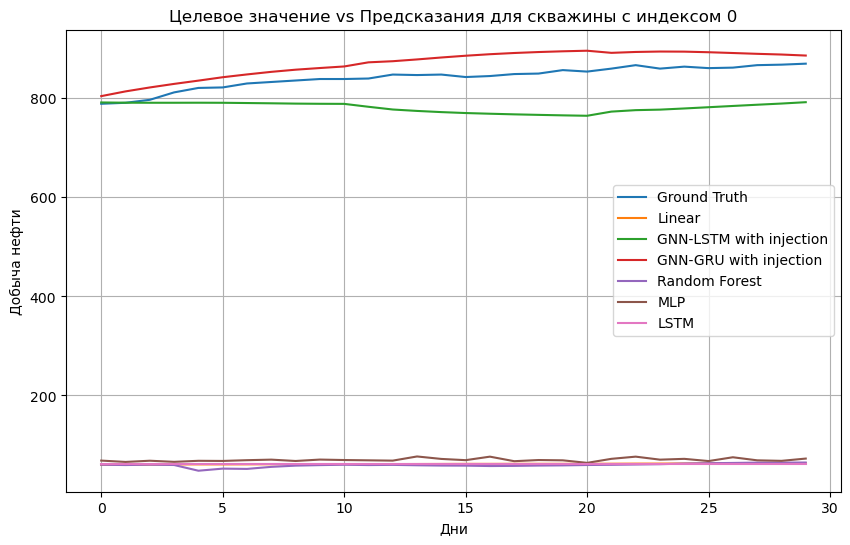

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(g_true, label='Ground Truth')
plt.plot(linear, label='Linear')
plt.plot(gnn_lstm, label='GNN-LSTM with injection')
plt.plot(gnn_gru, label='GNN-GRU with injection')
plt.plot(rf, label='Random Forest')
plt.plot(mlp, label='MLP')
plt.plot(lstm, label='LSTM')
plt.title(f'Целевое значение vs Предсказания для скважины с индексом {idx}')
plt.xlabel('Дни')
plt.ylabel('Добыча нефти')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
idx = 0

g_true = scaler_target.inverse_transform(y_lstm_test[idx].reshape(1, -1))[0]

gnn_orig = [791.67434781, 791.16795651, 791.05649956, 791.05617723,
       791.14431847, 791.00632245, 790.50046838, 789.96331181,
       789.33744096, 788.97867997, 788.81403743, 782.94134529,
       777.43479206, 774.55539218, 772.18446088, 770.294313  ,
       768.90124447, 767.65440945, 766.59234511, 765.61849365,
       764.78031022, 773.19795978, 776.12793075, 777.18945785,
       779.52693775, 782.053128  , 784.58709015, 787.06947839,
       789.46157649, 792.19459959]

gnn_increase = [791.67434781, 791.80729388, 795.78947999, 800.14067025,
       805.15089624, 809.992934  , 814.59783923, 818.96260345,
       823.11197498, 827.06977093, 830.84641354, 834.53892621,
       838.20156899, 841.8122439 , 845.44293951, 849.07370675,
       852.73792541, 856.31203298, 859.91464947, 863.56683421,
       867.30422334, 871.14085643, 875.12232624, 879.26406913,
       883.5851746 , 888.10634386, 892.86403679, 897.87057382,
       903.09175142, 908.47825205]

gnn_decrease = [791.67434781, 784.79911621, 776.05572728, 770.44018836,
       765.29139331, 760.93955838, 757.18845202, 753.89821582,
       751.04295539, 748.50917232, 746.21327389, 744.18441369,
       742.39902531, 740.7477649 , 739.28460599, 737.94096245,
       736.71744314, 735.44399742, 734.23817082, 733.09380313,
       732.0221045 , 731.01053962, 730.08414331, 729.2304877 ,
       728.4444154 , 727.72682179, 727.11814224, 726.66432767,
       726.42658629, 726.53048622]

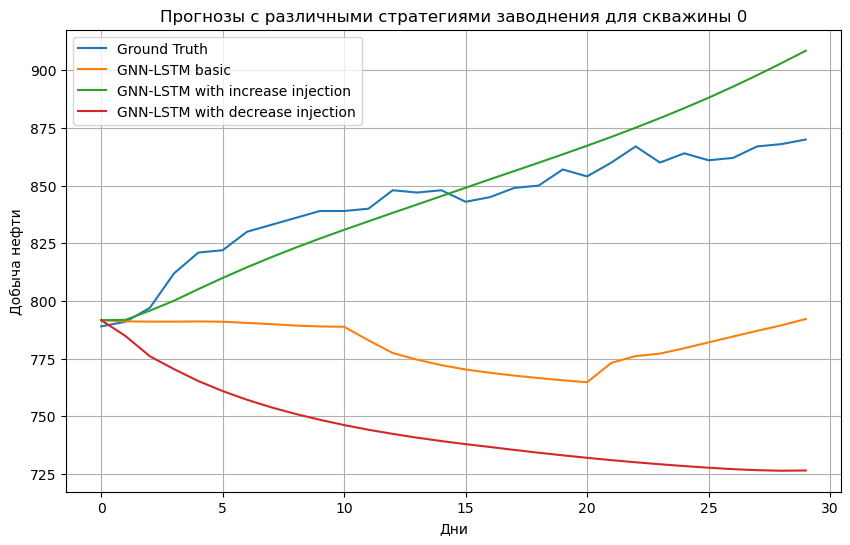

In [14]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.plot(g_true, label='Ground Truth')
# plt.plot(gnn_orig, label='GNN-GRU basic')
# plt.plot(gnn_increase, label='GNN-GRU with increase injection')
# plt.plot(gnn_decrease, label='GNN-GRU with decrease injection')
# plt.title(f'Прогнозы с различными стратегиями заводнения для скважины {idx}')
# plt.xlabel('Дни')
# plt.ylabel('Добыча нефти')
# plt.legend()
# plt.grid(True)
# plt.show()

plt.figure(figsize=(10, 6))
plt.plot(g_true, label='Ground Truth')
plt.plot(gnn_orig, label='GNN-LSTM basic')
plt.plot(gnn_increase, label='GNN-LSTM with increase injection')
plt.plot(gnn_decrease, label='GNN-LSTM with decrease injection')
plt.title(f'Прогнозы с различными стратегиями заводнения для скважины {idx}')
plt.xlabel('Дни')
plt.ylabel('Добыча нефти')
plt.legend()
plt.grid(True)
plt.show()

# Для тестов

In [16]:
import itertools
from scipy.stats import norm
from statsmodels.tsa.stattools import acovf

In [17]:
y_pred_lr = model_lr.predict(X_flat_test)
y_pred_lr_inv = scaler_target.inverse_transform(y_pred_lr)

y_pred_rf = model_rf.predict(X_flat_test)
y_pred_rf_inv = scaler_target.inverse_transform(y_pred_rf)

model_loaded_mlp.eval()
with torch.no_grad():
    y_pred_mlp = model_loaded_mlp(X_test_tensor).numpy()
y_pred_mlp_inv = scaler_target.inverse_transform(y_pred_mlp)

In [18]:
model_loaded_lstm.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X, batch_y
        outputs = model_loaded_lstm(batch_X)
        y_true.append(batch_y.numpy())
        y_pred.append(outputs.squeeze(-1).numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    y_true_inv = scaler_target.inverse_transform(y_true)
    y_pred_inv = scaler_target.inverse_transform(y_pred)

In [19]:
prod_wells_num = 205
res_matrix_num = int(77490 / prod_wells_num)


def collect_preds(preds):
    prod_res = []
    for i in range(res_matrix_num):
        prod_res.append(preds[i:i + 205, 0])
    return prod_res

In [20]:
y_pred_true_for_test = np.array(collect_preds(scaler_target.inverse_transform(y_true))).T

y_pred_lr_for_test = np.array(collect_preds(y_pred_lr_inv)).T
y_pred_rf_for_test = np.array(collect_preds(y_pred_rf_inv)).T
y_pred_mlp_for_test = np.array(collect_preds(y_pred_mlp_inv)).T
y_pred_lstm_for_test = np.array(collect_preds(y_pred_inv)).T

In [21]:
with open('gnn_lstm_1_for_test.pkl', 'rb') as file:
    gnn_lstm_1_for_test = pickle.load(file)

with open('gnn_gru_1_for_test.pkl', 'rb') as file:
    gnn_gru_1_for_test = pickle.load(file)

with open('gnn_lstm_1_for_test_no_water.pkl', 'rb') as file:
    gnn_lstm_1_for_test_no_water = pickle.load(file)

with open('gnn_gru_1_for_test_no_water.pkl', 'rb') as file:
    gnn_gru_1_for_test_no_water = pickle.load(file)

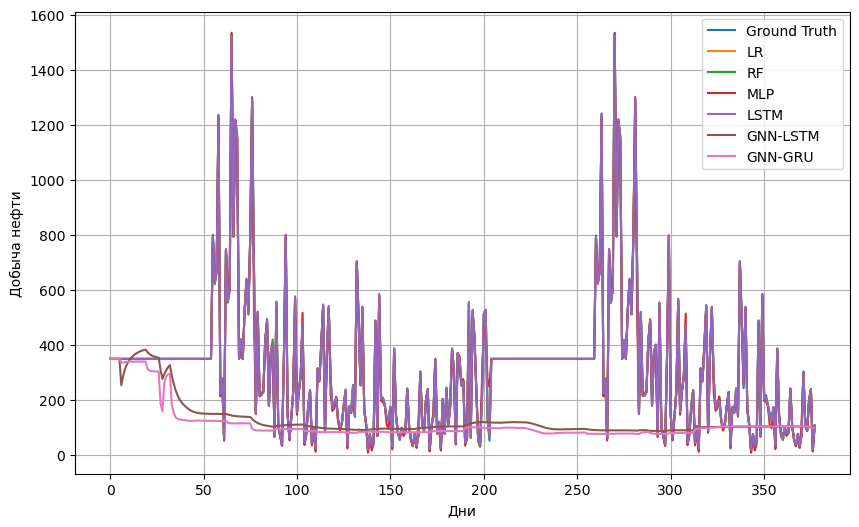

In [90]:
well = 150

plt.figure(figsize=(10, 6))
plt.plot(y_pred_true_for_test[well], label='Ground Truth')
plt.plot(y_pred_lr_for_test[well], label='LR')
plt.plot(y_pred_rf_for_test[well], label='RF')
plt.plot(y_pred_mlp_for_test[well], label='MLP')
plt.plot(y_pred_lstm_for_test[well], label='LSTM')
plt.plot(gnn_lstm_1_for_test[well], label='GNN-LSTM')
plt.plot(gnn_gru_1_for_test[well], label='GNN-GRU')
plt.xlabel('Дни')
plt.ylabel('Добыча нефти')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
def dm_test(e1, e2, d, h=1):
    """
    Выполняет тест Диболда-Мариано для сравнения двух прогнозных моделей,
    используя уже известные ошибки и разницу в потерях.

    Параметры:
        e1 (array-like): Ошибки первой модели.
        e2 (array-like): Ошибки второй модели.
        d (array-like): Разница в потерях между двумя моделями.
        h (int): Горизонт прогнозирования (число шагов вперед).

    Возвращает:
        dm_stat (float): Значение статистики Диболда-Мариано.
        p_value (float): p-value для двухстороннего теста.
    """
    # Проверка длины
    if not (len(e1) == len(e2) == len(d)):
        raise ValueError("Все входные массивы должны быть одинаковой длины.")
    
    # Проверка горизонта прогнозирования
    if h < 1:
        raise ValueError("Горизонт прогнозирования h должен быть >= 1.")

    # Среднее значение разницы в потерях
    mean_d = np.mean(d)

    # Расчёт автоковариаций
    n = len(d)
    if h > 1:
        max_lag = min(h - 1, n - 1)
        covs = acovf(d, nlag=max_lag)
        gamma_0 = covs[0]
        gamma_sum = 2 * np.sum(covs[1:max_lag + 1])
    else:
        gamma_0 = np.var(d)
        gamma_sum = 0

    # Дисперсия разницы в потерях с учётом автокорреляции
    variance = (gamma_0 + gamma_sum) / n
    se = np.sqrt(variance)

    # Статистика Диболда-Мариано
    dm_stat = mean_d / se

    # p-value для двухстороннего теста
    p_value = 2 * norm.sf(np.abs(dm_stat))

    return dm_stat, p_value

In [23]:
preds = [y_pred_lr_for_test, y_pred_rf_for_test, y_pred_mlp_for_test, y_pred_lstm_for_test]
# , gnn_lstm_1_for_test, gnn_gru_1_for_test
pairs = list(itertools.combinations(preds, 2))

for i, (mat1, mat2) in enumerate(pairs, 1):
    errors_a_flat = np.mean(y_pred_true_for_test - mat1, axis=0)
    errors_b_flat = np.mean(y_pred_true_for_test - mat2, axis=0)
    
    loss_diff = (errors_a_flat**2) - (errors_b_flat**2)
    dm_stat, p_value = dm_test(errors_a_flat, errors_b_flat, loss_diff, h=30)
    print(f"DM-статистика: {dm_stat:.4f}, p-value: {p_value:.4f}")

DM-статистика: -1.5264, p-value: 0.1269
DM-статистика: 0.5322, p-value: 0.5946
DM-статистика: -4.7924, p-value: 0.0000
DM-статистика: 0.7041, p-value: 0.4813
DM-статистика: -5.1043, p-value: 0.0000
DM-статистика: -3.1923, p-value: 0.0014


## GNN-LSTM vs GNN-LSTM no water

In [24]:
errors_a_flat = np.mean(y_pred_true_for_test - gnn_lstm_1_for_test, axis=0)
errors_b_flat = np.mean(y_pred_true_for_test - gnn_lstm_1_for_test_no_water, axis=0)

loss_diff = (errors_a_flat**2) - (errors_b_flat**2)
dm_stat, p_value = dm_test(errors_a_flat, errors_b_flat, loss_diff, h=30)
print(f"DM-статистика: {dm_stat:.4f}, p-value: {p_value:.4f}")

DM-статистика: 4.1048, p-value: 0.0000


## GNN-GRU vs GNN-GRU no water

In [25]:
errors_a_flat = np.mean(y_pred_true_for_test - gnn_gru_1_for_test, axis=0)
errors_b_flat = np.mean(y_pred_true_for_test - gnn_gru_1_for_test_no_water, axis=0)

loss_diff = (errors_a_flat**2) - (errors_b_flat**2)
dm_stat, p_value = dm_test(errors_a_flat, errors_b_flat, loss_diff, h=30)
print(f"DM-статистика: {dm_stat:.4f}, p-value: {p_value:.4f}")

DM-статистика: -6.2163, p-value: 0.0000


## GNN-GRU vs GNN-LSTM

In [26]:
errors_a_flat = np.mean(y_pred_true_for_test - gnn_lstm_1_for_test, axis=0)
errors_b_flat = np.mean(y_pred_true_for_test - gnn_gru_1_for_test, axis=0)

loss_diff = (errors_a_flat**2) - (errors_b_flat**2)
dm_stat, p_value = dm_test(errors_a_flat, errors_b_flat, loss_diff, h=30)
print(f"DM-статистика: {dm_stat:.4f}, p-value: {p_value:.4f}")

DM-статистика: -2.1741, p-value: 0.0297
